## English to Indonesian translation using attention

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

# Loss function: https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()

In [3]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

In [4]:
fp = open('./corpus/eng-indo.txt', 'r')
text = fp.read()
text = text.splitlines()
fp.close()

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


text_dict = {"English": [], "Indonesian": []}
for l in text:
    split_text = l.split("\t")
    text_dict["English"].append(normalizeString(split_text[0]))
    text_dict["Indonesian"].append(normalizeString(split_text[1]))
    
df = pd.DataFrame.from_dict(text_dict)
print(df.shape)
df.head()

(6752, 2)


,English,Indonesian
0,run !,lari !
1,who ?,siapa ?
2,wow !,wow !
3,help !,tolong !
4,jump !,lompat !


In [5]:
MAX_LENGTH = 25
MIN_LENGTH = 4

In [6]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
    "tom is", "tom s",
    "what s", "what a",
   "are you", "do you",
   "what is", "tom was",
   "don t", "it s", "where s",
   "where did", "where is",
)

def should_keep_row(row):
    """ Should the current row be kept as training set"""
    # indo_num_words = len(word_tokenize(row["Indonesian"]))
    eng_num_words = len(word_tokenize(row["English"]))
    max_words_required = MAX_LENGTH - 2
    min_words_required = MIN_LENGTH

    return min_words_required <= eng_num_words <= max_words_required

df["keep_row"] = df.apply(should_keep_row, axis=1)
print(df.shape)
df.head()

print("Current shape: " + str(df.shape))
df = df[df["keep_row"]]
print("New shape: " + str(df.shape))
df.head()
df = df.reset_index().drop(columns=["keep_row"])
df.head()

(6752, 3)
Current shape: (6752, 3)
New shape: (6609, 3)


,index,English,Indonesian
0,34,i m sad .,saya sedih .
1,35,it s me !,ini aku !
2,53,i get it .,aku mengerti .
3,54,i got it .,aku mengerti .
4,57,i m okay .,aku baik baik saja .


In [7]:
# Use a unique string to indicate START and END of a sentence.
# Assign a unique index to them.
START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1
UNK, UNK_IDX = 'UNK', 2

SOS_token = START_IDX
EOS_token = END_IDX

# We use this idiom to tokenize our sentences in the dataframe column:
# >>> DataFrame['column'].apply(str.lower).apply(word_tokenize)

# Also we added the START and the END symbol to the sentences. 
english_sents = [START] + df['English'].apply(str.lower).apply(word_tokenize) + [END]
indo_sents = [START] + df['Indonesian'].apply(str.lower).apply(word_tokenize) + [END]

# We're sort of getting into the data into the shape we want. 
# But now it's still too humanly readable and redundant.
## Cut-away: Computers like it to be simpler, more concise. -_-|||
print('First English sentence:', english_sents[0])
print('First Indo sentence:', indo_sents[0])

english_vocab = Dictionary([['<s>'], ['</s>'],['UNK']])
english_vocab.add_documents(english_sents)

indo_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
indo_vocab.add_documents(indo_sents)

# First ten words in the vocabulary.
print('First 10 Indonesian words in Dictionary:\n', sorted(indo_vocab.items())[:10])
print()
print('First 10 English words in Dictionary:\n', sorted(english_vocab.items())[:10])

english_vocab = Dictionary([['<s>'], ['</s>'],['UNK']])
english_vocab.add_documents(english_sents)

indo_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
indo_vocab.add_documents(indo_sents)

# First ten words in the vocabulary.
print('First 10 Indonesian words in Dictionary:\n', sorted(indo_vocab.items())[:10])
print()
print('First 10 English words in Dictionary:\n', sorted(english_vocab.items())[:10])

First English sentence: ['<s>', 'i', 'm', 'sad', '.', '</s>']
First Indo sentence: ['<s>', 'saya', 'sedih', '.', '</s>']
First 10 Indonesian words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, '.'), (4, 'saya'), (5, 'sedih'), (6, '!'), (7, 'aku'), (8, 'ini'), (9, 'mengerti')]

First 10 English words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, '.'), (4, 'i'), (5, 'm'), (6, 'sad'), (7, '!'), (8, 'it'), (9, 'me')]
First 10 Indonesian words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, '.'), (4, 'saya'), (5, 'sedih'), (6, '!'), (7, 'aku'), (8, 'ini'), (9, 'mengerti')]

First 10 English words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'UNK'), (3, '.'), (4, 'i'), (5, 'm'), (6, 'sad'), (7, '!'), (8, 'it'), (9, 'me')]


In [8]:
import pickle
# Lets save our dictionaries.
#with open('./vocabs/simple_indo_vocab.Dictionary.pkl', 'wb') as fout:
#    pickle.dump(indo_vocab, fout)
    
#with open('./vocabs/simple_english_vocab.Dictionary.pkl', 'wb') as fout:
#    pickle.dump(english_vocab, fout)

In [9]:
# Vectorizes a sentence with a given vocab
def vectorize_sent(sent, vocab):
    return vocab.doc2idx([START] + word_tokenize(sent.lower()) + [END], unknown_word_index=2)

# Creates a PyTorch variable from a sentence against a given vocab
def variable_from_sent(sent, vocab):
    vsent = vectorize_sent(sent, vocab)
    #print(vsent)
    result = Variable(torch.LongTensor(vsent).view(-1, 1))
    #print(result)
    return result.cuda() if use_cuda else result

# Test
new_kopi = "Is it love?"
variable_from_sent(new_kopi, english_vocab)

tensor([[ 0],
        [32],
        [ 8],
        [45],
        [15],
        [ 1]])

## Split into train and validation

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.15)
print(df_train.shape)
print(df_val.shape)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train.head()

indo_tensors = df_train['Indonesian'].apply(lambda s: variable_from_sent(s, indo_vocab))
print(df_train.iloc[0]['Indonesian'])
df_train

english_tensors = df_train['English'].apply(lambda s: variable_from_sent(s, english_vocab))
#print(df_train.iloc[0]['English'])
#print(english_tensors[0])
# Now, each item in `sent_pairs` is our data point. 
#print("############################")
sent_pairs = list(zip(english_tensors.values, indo_tensors.values))
#print(sent_pairs[:5])
#print("############################")
pairs = list(zip(df_train['English'], df_train['Indonesian']))
print(pairs[0])

(5617, 3)
(992, 3)
berbicara tentang wisata apa kau pernah ke kobe ?
('speaking about trips have you ever been to kobe ?', 'berbicara tentang wisata apa kau pernah ke kobe ?')


In [11]:
def get_validation_pairs():
    indo_val_tensors = df_val['Indonesian'].apply(lambda s: variable_from_sent(s, indo_vocab))
    english_val_tensors = df_val['English'].apply(lambda s: variable_from_sent(s, indo_vocab))
    val_sent_tensor_pairs = list(zip(english_val_tensors.values, indo_val_tensors.values))
    val_sent_pairs = list(zip(df_val['English'], df_val['Indonesian']))
    return val_sent_pairs, val_sent_tensor_pairs

val_sent_pairs, val_sent_tensor_pairs = get_validation_pairs()
print(val_sent_pairs[0])

('tom motioned for mary to follow him .', 'tom mengisyaratkan mary untuk mengikutinya .')


In [12]:
print(val_sent_pairs[-1])

('tom is growing a mustache .', 'tom menumbuhkan kumis .')


In [13]:
print(val_sent_pairs[154])

('tom looked confused .', 'tom terlihat kebingungan .')


In [14]:
print(val_sent_pairs[154][0])

for w in val_sent_pairs[154][0].split(' '):
    print(english_vocab.doc2idx([w]))

tom looked confused .
[21]
[197]
[693]
[3]


## Define model

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Get training and validation loss <- Bug here for evaluation loss

In [16]:
teacher_forcing_ratio = 0.5


def get_train_loss(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    #print("Train")
    #print("Input tensor shape: {0}".format(input_tensor.shape))
    #print("Target tensor shape: {0}".format(target_tensor.shape))

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def get_validation_loss(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    #print("Validation")
    #print("Input tensor shape: {0}".format(input_tensor.shape))
    #print("Target tensor shape: {0}".format(target_tensor.shape))

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    total_loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    with torch.no_grad():
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss = criterion(decoder_output, target_tensor[di])
            total_loss += float(loss.item())
            if decoder_input.item() == EOS_token:
                break

    return total_loss / target_length

## Utilities

In [17]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


SAVE_PATH = 'results'

if not os.path.exists(SAVE_PATH):
  os.makedirs(SAVE_PATH)

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Training loop and get evaluation result

In [23]:
def trainIters(encoder, decoder, n_iters, batch_size = 1, print_every=1000, save_every=1000, plot_every=100, learning_rate=0.0001):
    start = time.time()
    plot_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [sent_pairs[i] for i in range(n_iters)]
    training_pairs = [random.sample(sent_pairs, batch_size) for i in range(n_iters)]

    # training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    num_validation_records = 50

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        #print("################################")
        #print(training_pair)
        input_tensor = training_pair[0][0]
        target_tensor = training_pair[0][1]
        #print("printing tensors for training...")
        #print(input_tensor)
        #print(target_tensor)

        loss = get_train_loss(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss





        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Training loss: %s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

            total_val_loss = 0
            total_val_pairs = len(val_sent_tensor_pairs)
            for itr in range(0, num_validation_records):
                val_input_tensor = val_sent_tensor_pairs[itr][0]
                val_target_tensor = val_sent_tensor_pairs[itr][1]
                #print("Validation record: {0}".format(itr))
                #print(val_sent_pairs[itr])
                val_loss = get_validation_loss(val_input_tensor, val_target_tensor, encoder, decoder, criterion)
                total_val_loss += val_loss

            avg_val_loss = total_val_loss / total_val_pairs
            val_losses.append(avg_val_loss)
            print('Validation loss: %s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, avg_val_loss))

            print("##########################################################")

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
        # save trained encoder and decoder
        if iter % save_every == 0:
            encoder_save_path = '%s/%s-%d.pth' % (SAVE_PATH, 'encoder', iter)
            print('save encoder weights to ', encoder_save_path)
            torch.save(encoder.state_dict(), encoder_save_path)
            decoder_save_path = '%s/%s-%d.pth' % (SAVE_PATH, 'decoder', iter)
            print('save decoder weights to ', decoder_save_path)
            torch.save(decoder.state_dict(), decoder_save_path)

    showPlot(plot_losses)
    showPlot(val_losses)


def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        # input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = variable_from_sent(sentence, english_vocab)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('</s>')
                break
            else:
                decoded_words.append(indo_vocab.id2token[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Perform training

Training loss: 0m 6s (- 8m 24s) (100 1%) 8.3235
Validation loss: 0m 7s (- 8m 55s) (100 1%) 0.4184
##########################################################
Training loss: 0m 14s (- 8m 36s) (200 2%) 8.2784
Validation loss: 0m 14s (- 8m 51s) (200 2%) 0.4162
##########################################################
Training loss: 0m 21s (- 8m 41s) (300 4%) 8.2356
Validation loss: 0m 22s (- 8m 52s) (300 4%) 0.4129
##########################################################
Training loss: 0m 28s (- 8m 34s) (400 5%) 8.1654
Validation loss: 0m 29s (- 8m 42s) (400 5%) 0.4094
##########################################################
Training loss: 0m 36s (- 8m 28s) (500 6%) 8.0912
Validation loss: 0m 36s (- 8m 34s) (500 6%) 0.4049
##########################################################
Training loss: 0m 43s (- 8m 24s) (600 8%) 8.0295
Validation loss: 0m 44s (- 8m 29s) (600 8%) 0.4001
##########################################################
Training loss: 0m 51s (- 8m 17s) (700 9%) 7.9180

Validation loss: 5m 12s (- 2m 45s) (4900 65%) 0.1810
##########################################################
Training loss: 5m 19s (- 2m 39s) (5000 66%) 4.3425
Validation loss: 5m 19s (- 2m 39s) (5000 66%) 0.1800
##########################################################
save encoder weights to  results/encoder-5000.pth
save decoder weights to  results/decoder-5000.pth
Training loss: 5m 25s (- 2m 33s) (5100 68%) 4.6559
Validation loss: 5m 25s (- 2m 33s) (5100 68%) 0.1792
##########################################################
Training loss: 5m 31s (- 2m 26s) (5200 69%) 4.4214
Validation loss: 5m 31s (- 2m 26s) (5200 69%) 0.1787
##########################################################
Training loss: 5m 37s (- 2m 20s) (5300 70%) 4.4527
Validation loss: 5m 37s (- 2m 20s) (5300 70%) 0.1784
##########################################################
Training loss: 5m 43s (- 2m 13s) (5400 72%) 4.5230
Validation loss: 5m 44s (- 2m 13s) (5400 72%) 0.1776
################################

<Figure size 432x288 with 0 Axes>

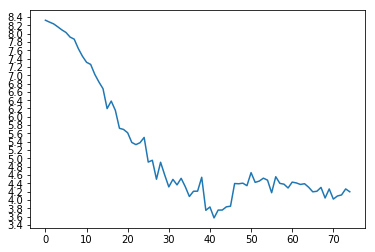

<Figure size 432x288 with 0 Axes>

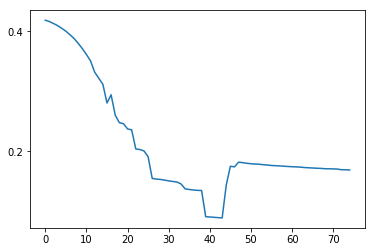

In [24]:
hidden_size = 256
encoder1 = EncoderRNN(len(english_vocab), hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, len(indo_vocab), dropout_p=0.001).to(device)

trainIters(encoder1, attn_decoder1, 7500, print_every=100)

evaluateRandomly(encoder1, attn_decoder1)

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "do you love me?")

## Check some translations

In [25]:
def translate(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

translate("tom is playing with ball.")

translate("she is standing there .")

translate("he is a bad man .")

translate("he wants to sleep .")

input = tom is playing with ball.
output = <s> <s> aku . </s>
input = she is standing there .
output = <s> <s> aku . </s>
input = he is a bad man .
output = <s> <s> aku . </s>
input = he wants to sleep .
output = <s> <s> tom . </s>
